# Laplacian Associative Memory (LAM) - DEV 19

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

- sigmaX Overlap Values

In [1]:
from nn import LAM
import libtools

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# np.random.seed(123)

---

#### LOAD DATA

In [4]:
src = np.load('../data/mat/SOM_orient_v1.npy')
src = libtools.downsample(src, 4)

print('Map:', src.shape)
print('Theta θ | min:', round(src.min(),4), 'max:', round(src.max(),4))

Map: (51, 51)
Theta θ | min: 0.0012 max: 6.282


---

### HYPER-PARAMETERS

In [5]:
N = 8192                            # Neurons | Default: 30000
prob = 0.1                          # Sparsity
eta = 0.01                          # Epsilon / Learning rate
epochs = 3000                       # Steps
gamma = 0.6                         # Inhibition ratio
norm_mode = 'asym'                  # Asymmetric Normalisation
alpha = -0.9                        # Ratio between local and global inhibition
P = src.shape[0] * src.shape[1]     # N Nodes

# Init condition (Center cell)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))
print('Start node:', start_node)

Start node: 1300


---

### COMPUTE

In [6]:
sigmaX = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 1.0]).astype(float)
sigmaA = 0.1

In [7]:
Wx, Vx, Mx = [],[],[]
ticker = len(sigmaX)

for i in tqdm(range(ticker)):
    W = libtools.construct_SOAM(src, sigmaX[i], sigmaA)

    _, v = libtools.GL_eigen(W, 'asym')

    graph = LAM(N, P, prob, W, gamma, "asym")
    graph._set_weight(alpha)
    m_log, obj_log = graph.simulate_single(alpha, eta, epochs, start_node)
    m = m_log[-1,:]

    Wx.append(W)
    Vx.append(v)
    Mx.append(m)

100%|██████████| 6/6 [14:31<00:00, 145.22s/it]


---

### PLOT

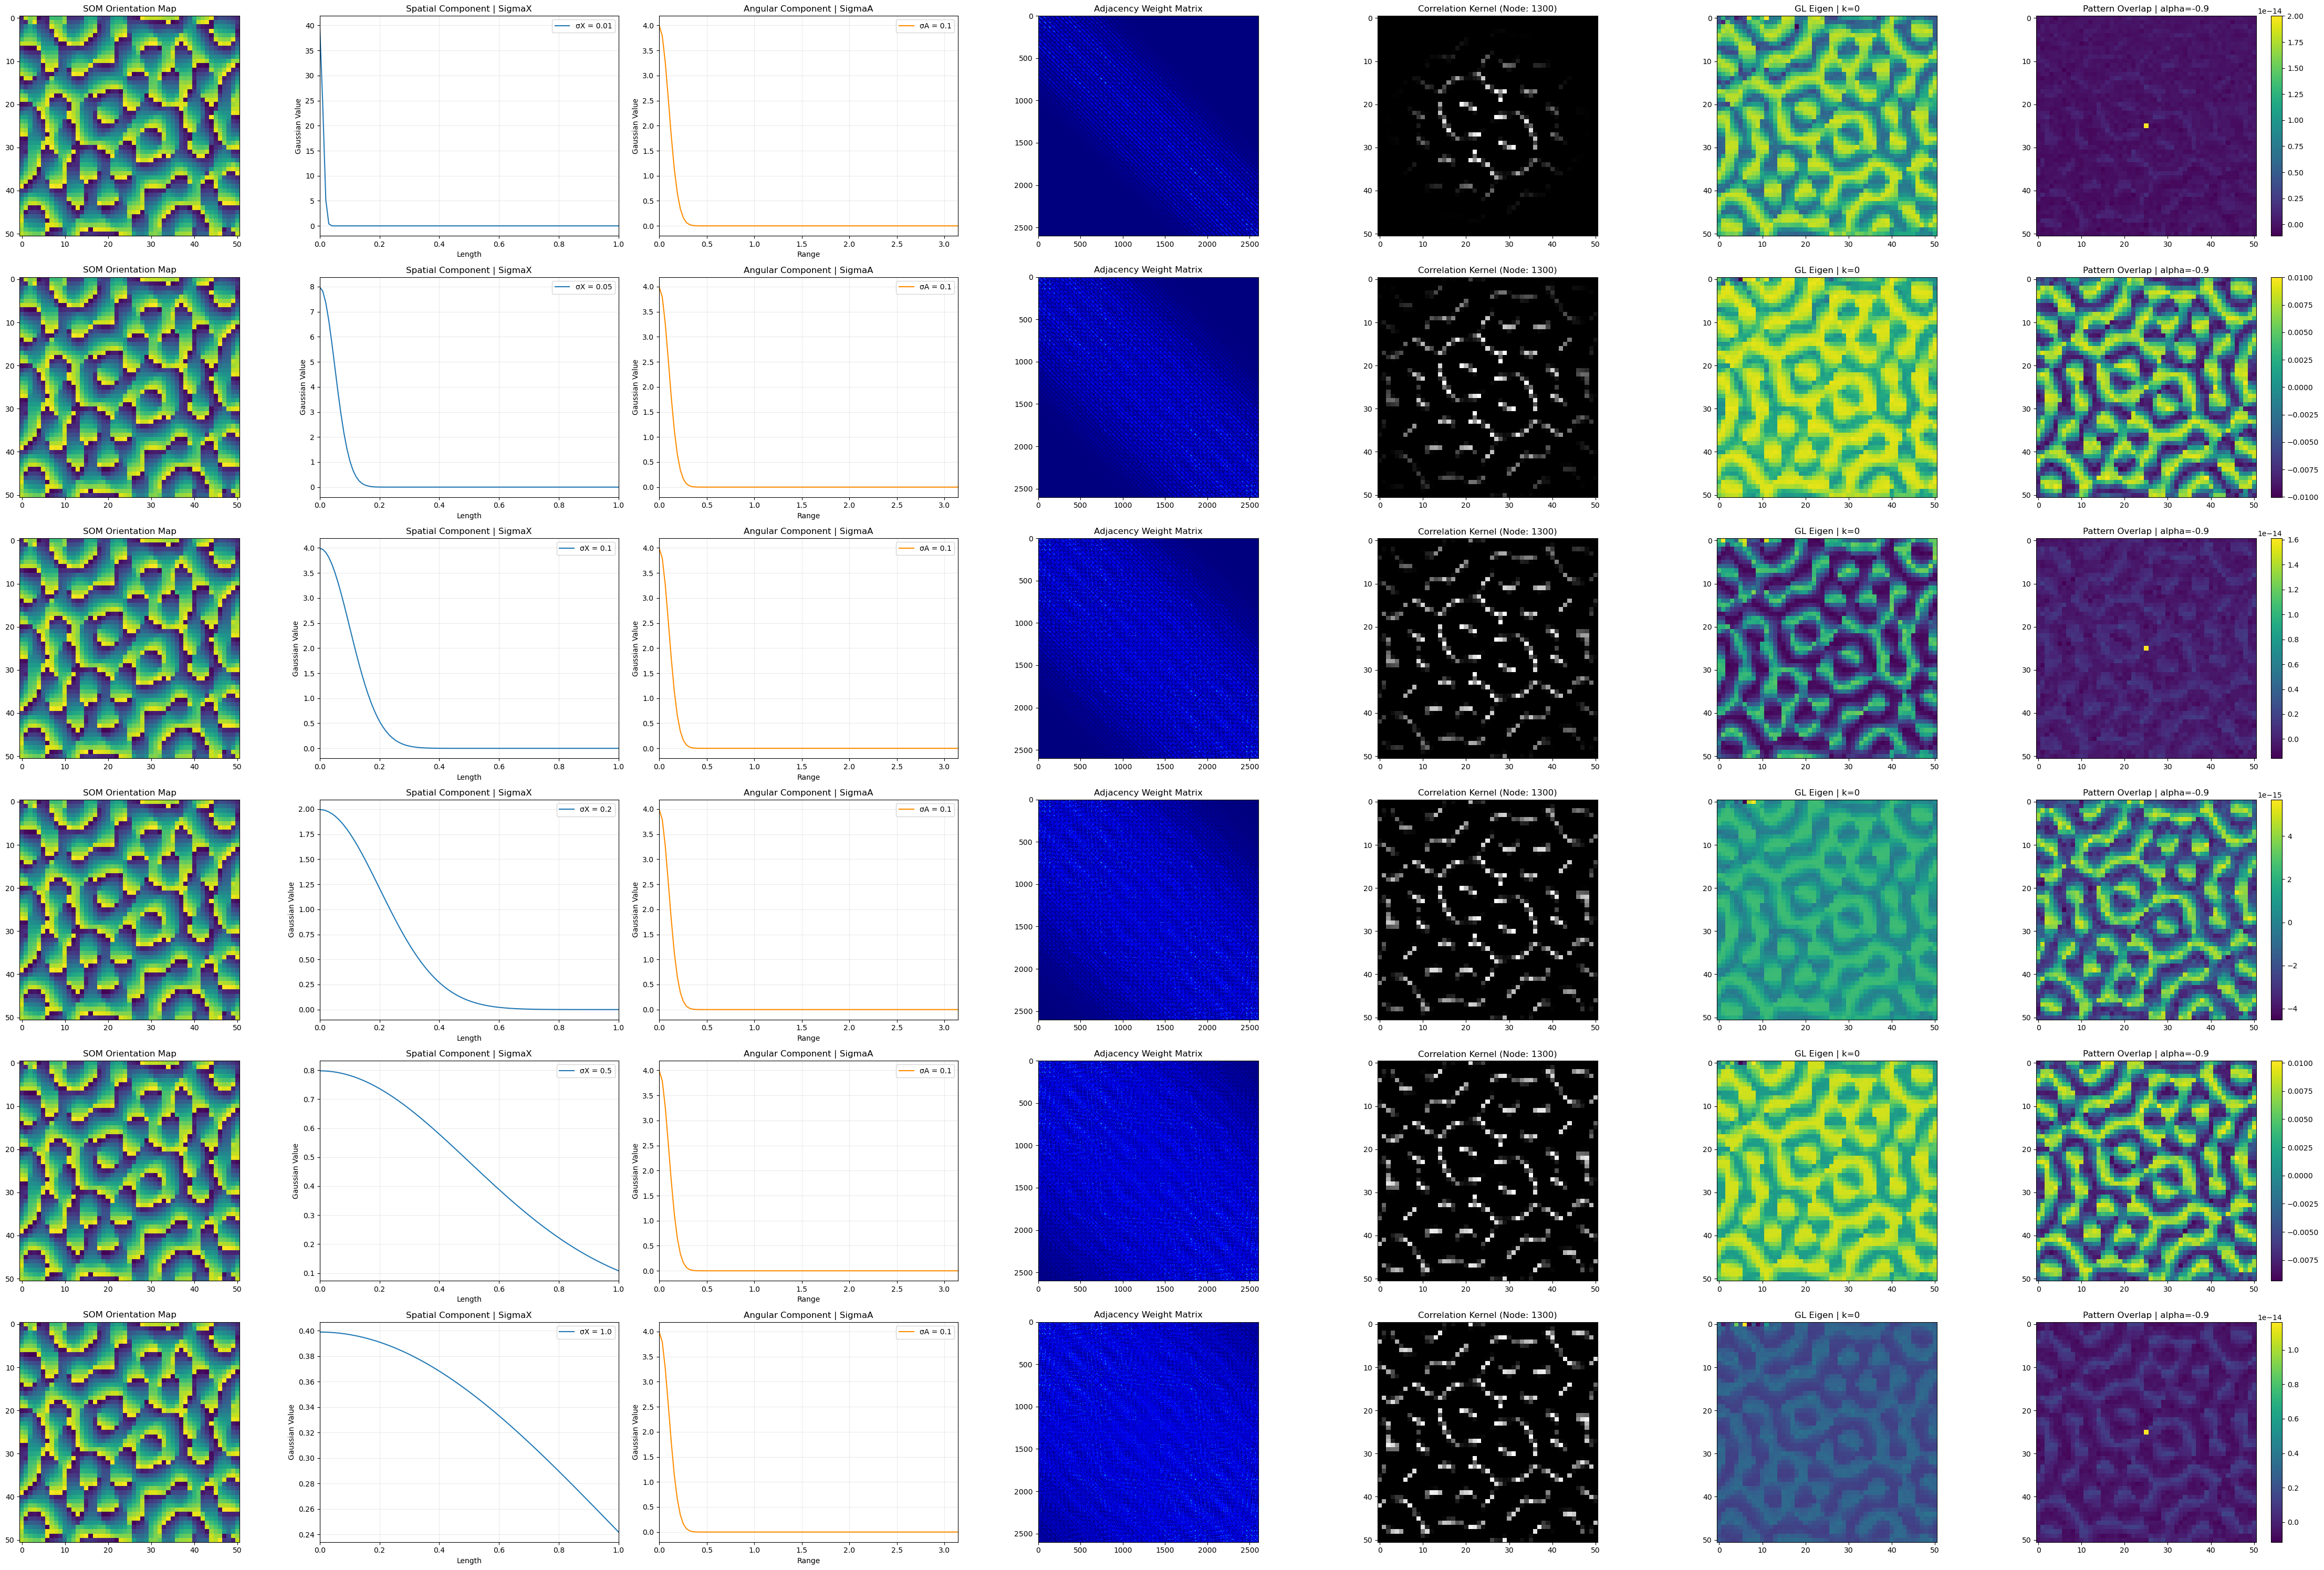

In [63]:
plt.figure(figsize=(45,5*ticker))
for i in range(ticker):
    plt.subplot(ticker, 7, i * 7 + 1)
    plt.imshow(src)
    plt.title('SOM Orientation Map')

    dist_s = np.linspace(0, 1, 100)
    dist_a = np.linspace(0, np.pi, 100)

    plt.subplot(ticker, 7, i * 7 + 2)
    plt.plot(dist_s, libtools.gaussian(dist_s, sigmaX[i]), label=f'σX = {sigmaX[i]}')
    plt.title('Spatial Component | SigmaX')
    plt.xlabel('Length'), plt.ylabel('Gaussian Value')
    plt.xlim([0, 1]), plt.grid(alpha=0.25), plt.legend()

    plt.subplot(ticker, 7, i * 7 + 3)
    plt.plot(dist_a, libtools.gaussian(dist_a, sigmaA), 'darkorange', label=f'σA = {sigmaA}')
    plt.title('Angular Component | SigmaA')
    plt.xlabel('Range'), plt.ylabel('Gaussian Value')
    plt.xlim([0, np.pi]), plt.grid(alpha=0.25), plt.legend()

    plt.subplot(ticker, 7, i * 7 + 4)
    plt.imshow(Wx[i], 'jet')
    plt.title('Adjacency Weight Matrix')

    plt.subplot(ticker, 7, i * 7 + 5)
    plt.imshow(Wx[i][start_node].reshape(src.shape), 'gray')
    plt.title('Correlation Kernel (Node: ' + str(start_node) + ')')

    plt.subplot(ticker, 7, i * 7 + 6)
    k = 0
    plt.imshow(Vx[i][:,k].reshape(src.shape))
    plt.title('GL Eigen | k='+ str(k))

    plt.subplot(ticker, 7, i * 7 + 7)
    plt.imshow(Mx[i].reshape(src.shape))
    plt.title('Pattern Overlap | alpha=' + str(alpha))
    plt.colorbar()

plt.tight_layout()

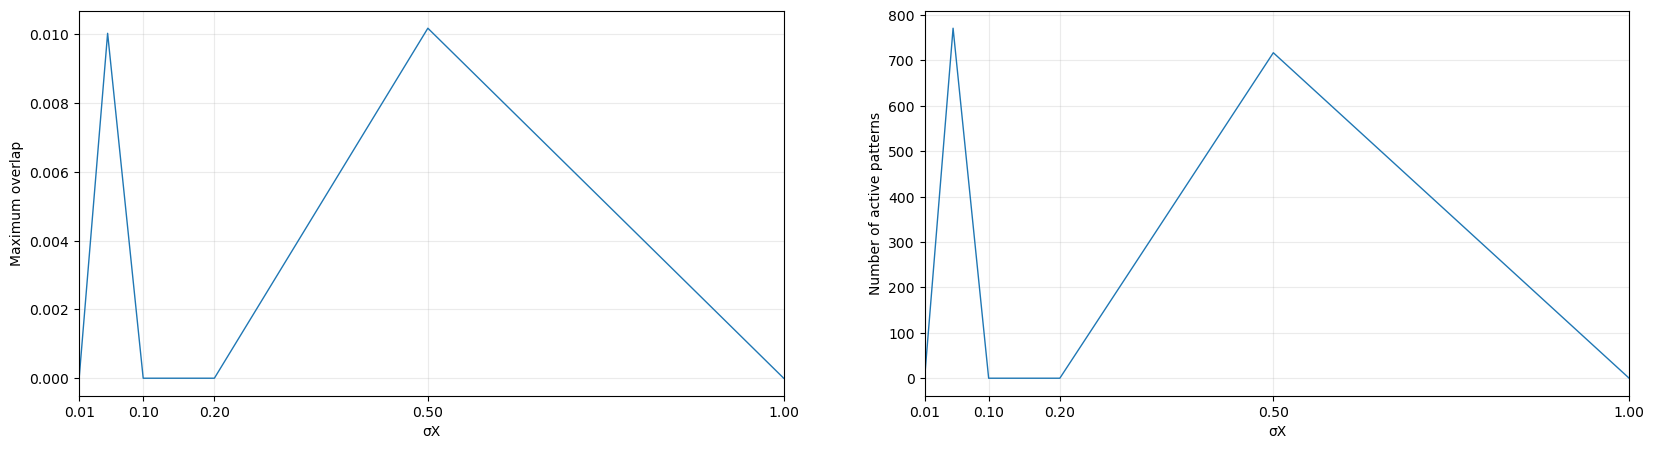

In [73]:
Na = len(sigmaX)
max_overlap = np.zeros(Na)
Nactive = np.zeros(Na)

for sx in range(Na):
    m = Mx[sx]
    max_m = np.max(m)
    max_overlap[sx] = max_m
    Nactive[sx] = np.mean(np.sum((m > 0.5*max_m) * (m > 1e-4), axis=0))

xlim=[0.01, np.max(sigmaX)]
xticks=[0.01, 0.1, 0.2, 0.5, xlim[1]]

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(sigmaX, max_overlap, lw=1)
plt.xlabel("σX"), plt.ylabel("Maximum overlap")
plt.xlim(xlim), plt.xticks(xticks)
plt.grid('on', alpha=0.25)

plt.subplot(1,2,2)
plt.plot(sigmaX, Nactive, lw=1)
plt.xlabel("σX"), plt.ylabel("Number of active patterns")
plt.xlim(xlim), plt.xticks(xticks)
plt.grid('on', alpha=0.25)